<a href="https://colab.research.google.com/github/Francho03/Praca-licencjacka/blob/main/codes/Analiza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# Krok 1: Wczytanie danych
sprawozdanie_przemoc = pd.read_excel('/content/drive/MyDrive/praca_licencjacka/Sprawozdanie_2014_2023_zagregowane.xlsx',dtype={"keso": str})
dane_korelujace = pd.read_excel('/content/drive/MyDrive/praca_licencjacka/Dane korelujace/dane_korelujace.xlsx',  dtype={"kod": str})
dane_korelujace

,kod,pow,rok,odsetek_bezrobotnych_dlugotrwalych,wielkosc_wynagrodzenia,odsetek_rozwodow,liczba_osob_na_1_izbe,przecietna_powiechnia_mieszkania_na_1_osobe
0,0201000,Powiat bolesławiecki,2014,0.4637,3422,0.3787,0.72,26.5
1,0202000,Powiat dzierżoniowski,2014,0.4751,3299,0.4310,0.76,24.0
2,0203000,Powiat głogowski,2014,0.5690,3460,0.4189,0.75,23.2
3,0204000,Powiat górowski,2014,0.6394,3142,0.3918,0.77,25.0
4,0205000,Powiat jaworski,2014,0.5921,3142,0.3508,0.75,25.2
...,...,...,...,...,...,...,...,...
3795,3217000,Powiat wałecki,2023,0.4854,6651,0.3410,0.66,28.6
3796,3218000,Powiat łobeski,2023,0.5389,6257,0.4160,0.67,27.5
3797,3261000,Powiat m. Koszalin,2023,0.4891,6828,0.4439,0.60,30.6
3798,3262000,Powiat m. Szczecin,2023,0.3982,7933,0.3940,0.59,30.9


In [5]:
sprawozdanie_przemoc

,woj,pow,rok,keso,liczba_proc_nk_a,liczba_proc_nk_c,rodziny_wszczete,liczba_osob_ogol,liczba_osob_kobiety,liczba_osob_mezczyzni,liczba_osob_dzieci
0,dolnośląskie,bolesławiecki,2023,300201011000,42,181,383,493,294.0,95.0,104.0
1,dolnośląskie,dzierżoniowski,2023,300202011000,65,132,291,402,216.0,26.0,160.0
2,dolnośląskie,górowski,2023,300204013000,23,56,125,273,211.0,23.0,39.0
3,dolnośląskie,głogowski,2023,200203000000,36,199,428,770,333.0,72.0,365.0
4,dolnośląskie,jaworski,2023,300205023000,12,59,119,123,93.0,8.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...
3805,świętokrzyskie,sandomierski,2014,302609022000,8,220,145,196,NaN,NaN,NaN
3806,świętokrzyskie,skarżyski,2014,302610022000,32,62,166,215,NaN,NaN,NaN
3807,świętokrzyskie,starachowicki,2014,302611022000,4,80,218,680,NaN,NaN,NaN
3808,świętokrzyskie,staszowski,2014,302612012000,21,199,216,449,NaN,NaN,NaN


In [6]:
pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 6.3 MB/s eta 0:00:00


In [7]:
import unidecode


spra_names = sprawozdanie_przemoc['pow'].dropna().str.strip().str.lower().unique()
kor_names = dane_korelujace['pow'].dropna().str.strip().str.lower().unique()

# Print raw differences
missing_in_geo = set(spra_names) - set(kor_names)
print("❌ Powiaty in Sprawozdanie but missing in kor:", missing_in_geo)

missing_in_spra = set(kor_names) - set(spra_names)
print("❌ Powiaty in kor but missing in Sprawozdanie:", missing_in_spra)

# Define normalization function
def normalize_powiat_name(name: str) -> str:
    name = name.lower().strip()
    name = unidecode.unidecode(name)  # remove accents
    for prefix in ["powiat "]:
        if name.startswith(prefix):
            name = name.replace(prefix, "")
    return name.strip()

# Normalize both name sets
sprawozdanie_normalized = {normalize_powiat_name(n) for n in spra_names}
kor_normalized = {normalize_powiat_name(n) for n in kor_names}

# Compare normalized names
missing_in_kor = sprawozdanie_normalized - kor_normalized
missing_in_sprawozdanie = kor_normalized - sprawozdanie_normalized

# Print normalized differences
print("✅ After normalization:")
print("❌ Still missing in dane_koreujace:", missing_in_kor)
print("❌ Still missing in Sprawozdanie:", missing_in_sprawozdanie)


❌ Powiaty in Sprawozdanie but missing in kor: {'m. wrocław', 'lubański', 'staszowski', 'sejneński', 'krotoszyński', 'aleksandrowski', 'tarnowski', 'ełcki', 'lubiński', 'nowosądecki', 'm. zabrze', 'sępoleński', 'dębicki', 'kartuski', 'wieruszowski', 'międzychodzki', 'gorzowski', 'żywiecki', 'oławski', 'grudziądzki', 'tucholski', 'zduńskowolski', 'jarosławski', 'sieradzki', 'kłobucki', 'ostrzeszowski', 'm. kielce', 'zgorzelecki', 'białostocki', 'm. opole', 'kozienicki', 'mrągowski', 'chojnicki', 'łęczyński', 'białogardzki', 'wołomiński', 'człuchowski', 'świecki', 'brzeski', 'parczewski', 'piaseczyński', 'nowotarski', 'suski', 'myszkowski', 'm. bydgoszcz', 'lipski', 'ostrołęcki', 'złotoryjski', 'kościerski', 'szamotulski', 'kamieński', 'leski', 'm. jelenia góra', 'wrzesiński', 'strzeliński', 'stargardzki', 'hajnowski', 'bocheński', 'nowotomyski', 'ząbkowicki', 'bytowski', 'olecki', 'kędzierzyńsko-kozielski', 'żniński', 'tomaszowski', 'm. zamość', 'zwoleński', 'sochaczewski', 'kamiennogórs

In [8]:
manual_corrections = {
    "m. walbrzych od 2013": "m. walbrzych",
}

In [9]:
# Zastosuj korekty po normalizacji
sprawozdanie_normalized_corrected = {
    manual_corrections.get(n, n) for n in sprawozdanie_normalized
}
kor_normalized_corrected = {
    manual_corrections.get(n, n) for n in kor_normalized
}

# Porównanie po korekcie
final_missing_in_kor = sprawozdanie_normalized_corrected - kor_normalized_corrected
final_missing_in_sprawozdanie = kor_normalized_corrected - sprawozdanie_normalized_corrected

print("🧹 After manual correction:")
print("❌ Still missing in korelacja:", final_missing_in_kor)
print("❌ Still missing in Sprawozdanie:", final_missing_in_sprawozdanie)

🧹 After manual correction:
❌ Still missing in korelacja: set()
❌ Still missing in Sprawozdanie: set()


In [10]:
# Zastosuj normalizację i korektę do kolumny 'pow'
def correct_powiat_name(name):
    if pd.isna(name):
        return name
    name_norm = normalize_powiat_name(name)
    return manual_corrections.get(name_norm, name_norm)

sprawozdanie_przemoc["pow"] = sprawozdanie_przemoc["pow"].apply(correct_powiat_name)


In [11]:
dane_korelujace["pow"] = dane_korelujace["pow"].apply(correct_powiat_name)


In [12]:
dane_korelujace

,kod,pow,rok,odsetek_bezrobotnych_dlugotrwalych,wielkosc_wynagrodzenia,odsetek_rozwodow,liczba_osob_na_1_izbe,przecietna_powiechnia_mieszkania_na_1_osobe
0,0201000,boleslawiecki,2014,0.4637,3422,0.3787,0.72,26.5
1,0202000,dzierzoniowski,2014,0.4751,3299,0.4310,0.76,24.0
2,0203000,glogowski,2014,0.5690,3460,0.4189,0.75,23.2
3,0204000,gorowski,2014,0.6394,3142,0.3918,0.77,25.0
4,0205000,jaworski,2014,0.5921,3142,0.3508,0.75,25.2
...,...,...,...,...,...,...,...,...
3795,3217000,walecki,2023,0.4854,6651,0.3410,0.66,28.6
3796,3218000,lobeski,2023,0.5389,6257,0.4160,0.67,27.5
3797,3261000,m. koszalin,2023,0.4891,6828,0.4439,0.60,30.6
3798,3262000,m. szczecin,2023,0.3982,7933,0.3940,0.59,30.9


In [13]:
# Extract first 2 digits of keso as woj_code
dane_korelujace["woj_kod"] = dane_korelujace["kod"].astype(str).str[:2]

# Map to województwo name
wojewodztwa_map = {
    "02": "dolnośląskie",
    "04": "kujawsko - pomorskie",
    "06": "lubelskie",
    "08": "lubuskie",
    "10": "łódzkie",
    "12": "małopolskie",
    "14": "mazowieckie",
    "16": "opolskie",
    "18": "podkarpackie",
    "20": "podlaskie",
    "22": "pomorskie",
    "24": "śląskie",
    "26": "świętokrzyskie",
    "28": "warmińsko-mazurskie",
    "30": "wielkopolskie",
    "32": "zachodniopomorskie"
}

dane_korelujace["woj"] = dane_korelujace["woj_kod"].map(wojewodztwa_map)

In [14]:
dane_korelujace

,kod,pow,rok,odsetek_bezrobotnych_dlugotrwalych,wielkosc_wynagrodzenia,odsetek_rozwodow,liczba_osob_na_1_izbe,przecietna_powiechnia_mieszkania_na_1_osobe,woj_kod,woj
0,0201000,boleslawiecki,2014,0.4637,3422,0.3787,0.72,26.5,02,dolnośląskie
1,0202000,dzierzoniowski,2014,0.4751,3299,0.4310,0.76,24.0,02,dolnośląskie
2,0203000,glogowski,2014,0.5690,3460,0.4189,0.75,23.2,02,dolnośląskie
3,0204000,gorowski,2014,0.6394,3142,0.3918,0.77,25.0,02,dolnośląskie
4,0205000,jaworski,2014,0.5921,3142,0.3508,0.75,25.2,02,dolnośląskie
...,...,...,...,...,...,...,...,...,...,...
3795,3217000,walecki,2023,0.4854,6651,0.3410,0.66,28.6,32,zachodniopomorskie
3796,3218000,lobeski,2023,0.5389,6257,0.4160,0.67,27.5,32,zachodniopomorskie
3797,3261000,m. koszalin,2023,0.4891,6828,0.4439,0.60,30.6,32,zachodniopomorskie
3798,3262000,m. szczecin,2023,0.3982,7933,0.3940,0.59,30.9,32,zachodniopomorskie


In [15]:
sprawozdanie_przemoc["pow"].nunique()
dane_korelujace["pow"].nunique()

370

In [16]:
print("sprawozdanie_przemoc rows per powiat:")
print(sprawozdanie_przemoc["pow"].value_counts().describe())

print("\ndane_korelujace rows per powiat:")
print(dane_korelujace["pow"].value_counts().describe())

sprawozdanie_przemoc rows per powiat:
count    370.000000
mean      10.297297
std        1.700707
min       10.000000
25%       10.000000
50%       10.000000
75%       10.000000
max       20.000000
Name: count, dtype: float64

dane_korelujace rows per powiat:
count    370.000000
mean      10.270270
std        1.623817
min       10.000000
25%       10.000000
50%       10.000000
75%       10.000000
max       20.000000
Name: count, dtype: float64


In [17]:
expected_rows_per_pow = 10

# Group and count
spra_counts = sprawozdanie_przemoc["pow"].value_counts()
kor_counts = dane_korelujace["pow"].value_counts()

# Find powiats with fewer than expected rows
print("⛔ Powiats in dane_korelujace with < 10 rows:")
print(kor_counts[kor_counts < expected_rows_per_pow])

print("\n⛔ Powiats in sprawozdanie_przemoc with ≠ 10 rows:")
print(spra_counts[spra_counts != expected_rows_per_pow])


⛔ Powiats in dane_korelujace with < 10 rows:
Series([], Name: count, dtype: int64)

⛔ Powiats in sprawozdanie_przemoc with ≠ 10 rows:
pow
bielski        20
brzeski        20
ostrowski      20
nowodworski    20
krosnienski    20
tomaszowski    20
opolski        20
chelmski       20
swidnicki      20
sredzki        20
grodziski      20
Name: count, dtype: int64


In [18]:
chelmski_df = sprawozdanie_przemoc[sprawozdanie_przemoc["pow"] == "chelmski"]
rest_df = sprawozdanie_przemoc[sprawozdanie_przemoc["pow"] != "chelmski"]



In [19]:
# Get numeric columns (excluding 'rok' if needed)
numeric_cols = chelmski_df.select_dtypes(include='number').columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'rok']

# Group and aggregate
chelmski_agg = chelmski_df.groupby(["pow", "rok"]).agg({
    **{col: 'sum' for col in numeric_cols},
    'woj': 'first',   # keep the first woj value
    'keso': 'first'   # keep the first keso value
}).reset_index()



In [20]:
sprawozdanie_cleaned = pd.concat([rest_df, chelmski_agg], ignore_index=True)


In [21]:
sprawozdanie_cleaned = sprawozdanie_cleaned.sort_values(by=["rok", "woj"], ascending=[False, True])


In [22]:
sprawozdanie_przemoc=sprawozdanie_cleaned
sprawozdanie_przemoc

,woj,pow,rok,keso,liczba_proc_nk_a,liczba_proc_nk_c,rodziny_wszczete,liczba_osob_ogol,liczba_osob_kobiety,liczba_osob_mezczyzni,liczba_osob_dzieci
0,dolnośląskie,boleslawiecki,2023,300201011000,42,181,383,493,294.0,95.0,104.0
1,dolnośląskie,dzierzoniowski,2023,300202011000,65,132,291,402,216.0,26.0,160.0
2,dolnośląskie,gorowski,2023,300204013000,23,56,125,273,211.0,23.0,39.0
3,dolnośląskie,glogowski,2023,200203000000,36,199,428,770,333.0,72.0,365.0
4,dolnośląskie,jaworski,2023,300205023000,12,59,119,123,93.0,8.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...
3785,świętokrzyskie,sandomierski,2014,302609022000,8,220,145,196,NaN,NaN,NaN
3786,świętokrzyskie,skarzyski,2014,302610022000,32,62,166,215,NaN,NaN,NaN
3787,świętokrzyskie,starachowicki,2014,302611022000,4,80,218,680,NaN,NaN,NaN
3788,świętokrzyskie,staszowski,2014,302612012000,21,199,216,449,NaN,NaN,NaN


In [23]:
# Warunek logiczny
mask = (sprawozdanie_przemoc["pow"] == "chelmski") & (sprawozdanie_przemoc["rok"] == 2014)

# Zamiana 0 na NaN tylko w wybranych wierszach
sprawozdanie_przemoc.loc[mask] = sprawozdanie_przemoc.loc[mask].replace(0, np.nan)

In [24]:
sprawozdanie_przemoc[sprawozdanie_przemoc["pow"] == "chelmski"]

,woj,pow,rok,keso,liczba_proc_nk_a,liczba_proc_nk_c,rodziny_wszczete,liczba_osob_ogol,liczba_osob_kobiety,liczba_osob_mezczyzni,liczba_osob_dzieci
3799,lubelskie,chelmski,2023,300603022000,27,86,175,279,150.0,16.0,113.0
3798,lubelskie,chelmski,2022,300603022000,15,84,164,249,149.0,21.0,79.0
3797,lubelskie,chelmski,2021,300603022000,131,123,197,354,205.0,61.0,88.0
3796,lubelskie,chelmski,2020,300603022000,33,167,205,438,263.0,65.0,110.0
3795,lubelskie,chelmski,2019,300603022000,35,176,232,466,249.0,75.0,142.0
3794,lubelskie,chelmski,2018,300603022000,27,179,243,629,343.0,56.0,230.0
3793,lubelskie,chelmski,2017,300603022000,31,198,277,656,381.0,56.0,219.0
3792,lubelskie,chelmski,2016,300603022000,40,174,195,443,260.0,50.0,133.0
3791,lubelskie,chelmski,2015,300603022000,42,194,158,355,229.0,53.0,73.0
3790,lubelskie,chelmski,2014,300603022000,32,167,188,321,NaN,NaN,NaN


In [25]:
sprawozdanie_przemoc.to_excel("/content/drive/MyDrive/praca_licencjacka/Sprawozdanie_2014_2023_zagregowane_corrected.xlsx", sheet_name= "Sprawozdanie_2014_2023_zagregowane_corrected.xlsx" ,index=False)

/usr/local/lib/python3.11/dist-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [26]:
with pd.ExcelWriter('Sprawozdanie_przemoc_2014_2023_zagregowane_corrected.xlsx') as writer:
 sprawozdanie_przemoc .to_excel(writer, index=False, sheet_name='Sprawozdanie_przemoc_2014_2023_zagregowane_corrected')

In [27]:
sprawozdanie_przemoc.to_csv('Sprawozdanie_przemoc_2014_2023_zagregowane_corrected.csv', index=False)

In [28]:


# Standaryzacja nazw powiatów
# Usuwamy 'powiat ' z dane_korelujace i stosujemy lowercase oraz strip
dane_korelujace['pow'] = dane_korelujace['pow'].str.replace('powiat ', '', regex=False).str.strip().str.lower()
sprawozdanie_przemoc['pow'] = sprawozdanie_przemoc['pow'].str.strip().str.lower()

# Upewniamy się, że 'rok' ma ten sam typ danych (int)
sprawozdanie_przemoc['rok'] = sprawozdanie_przemoc['rok'].astype(int)
dane_korelujace['rok'] = dane_korelujace['rok'].astype(int)

# Krok 2: Połączenie danych
df_merged = pd.merge(
    sprawozdanie_przemoc,
    dane_korelujace,
    on=["woj", "pow", "rok"],
    how="inner"
)

# Diagnostyka: Sprawdzamy, ile wierszy mamy po połączeniu
print(f"Liczba wierszy w df_merged: {df_merged.shape[0]}")
print("Unikalne powiaty w sprawozdanie_przemoc:", sprawozdanie_przemoc['pow'].nunique())
print("Unikalne powiaty w dane_korelujace:", dane_korelujace['pow'].nunique())

# Krok 3: Przygotowanie danych do korelacji
df_merged['liczba_osob_ogol'] = pd.to_numeric(df_merged['liczba_osob_ogol'], errors='coerce')
df_merged['odsetek_bezrobotnych_dlugotrwalych'] = pd.to_numeric(df_merged['odsetek_bezrobotnych_dlugotrwalych'], errors='coerce')
df_clean = df_merged.dropna(subset=['liczba_osob_ogol', 'odsetek_bezrobotnych_dlugotrwalych'])

# Diagnostyka: Sprawdzamy, ile wierszy zostało po usunięciu NaN
print(f"Liczba wierszy w df_clean: {df_clean.shape[0]}")

# Krok 4: Obliczenie korelacji, jeśli mamy wystarczająco danych
if df_clean.shape[0] >= 2:
    correlation, p_value = pearsonr(df_clean['liczba_osob_ogol'], df_clean['odsetek_bezrobotnych_dlugotrwalych'])
    print(f"Korelacja między liczbą osób ogółem a odsetkiem bezrobotnych długotrwale: {correlation:.3f}")
    print(f"P-wartość: {p_value:.3f}")
else:
    print("Za mało danych do obliczenia korelacji. Sprawdź dane wejściowe.")
    print("Brakujące wartości w 'liczba_osob_ogol':", df_merged['liczba_osob_ogol'].isnull().sum())
    print("Brakujące wartości w 'odsetek_bezrobotnych_dlugotrwalych':", df_merged['odsetek_bezrobotnych_dlugotrwalych'].isnull().sum())

Liczba wierszy w df_merged: 3800
Unikalne powiaty w sprawozdanie_przemoc: 370
Unikalne powiaty w dane_korelujace: 370
Liczba wierszy w df_clean: 3800
Korelacja między liczbą osób ogółem a odsetkiem bezrobotnych długotrwale: -0.100
P-wartość: 0.000


In [29]:

# Standaryzacja nazw powiatów
# Usuwamy 'powiat ' z dane_korelujace i stosujemy lowercase oraz strip
dane_korelujace['pow'] = dane_korelujace['pow'].str.replace('powiat ', '', regex=False).str.strip().str.lower()
sprawozdanie_przemoc['pow'] = sprawozdanie_przemoc['pow'].str.strip().str.lower()

# Upewniamy się, że 'rok' ma ten sam typ danych (int)
sprawozdanie_przemoc['rok'] = sprawozdanie_przemoc['rok'].astype(int)
dane_korelujace['rok'] = dane_korelujace['rok'].astype(int)

# Krok 2: Połączenie danych
df_merged = pd.merge(
    sprawozdanie_przemoc,
    dane_korelujace,
    on=["woj", "pow", "rok"],
    how="inner"
)

# Diagnostyka: Sprawdzamy, ile wierszy mamy po połączeniu
print(f"Liczba wierszy w df_merged: {df_merged.shape[0]}")
print("Unikalne powiaty w sprawozdanie_przemoc:", sprawozdanie_przemoc['pow'].nunique())
print("Unikalne powiaty w dane_korelujace:", dane_korelujace['pow'].nunique())

# Krok 3: Przygotowanie danych do korelacji
df_merged['liczba_osob_ogol'] = pd.to_numeric(df_merged['liczba_osob_ogol'], errors='coerce')
df_merged['wielkosc_wynagrodzenia'] = pd.to_numeric(df_merged['wielkosc_wynagrodzenia'], errors='coerce')
df_clean = df_merged.dropna(subset=['liczba_osob_ogol', 'wielkosc_wynagrodzenia'])

# Diagnostyka: Sprawdzamy, ile wierszy zostało po usunięciu NaN
print(f"Liczba wierszy w df_clean: {df_clean.shape[0]}")

# Krok 4: Obliczenie korelacji, jeśli mamy wystarczająco danych
if df_clean.shape[0] >= 2:
    correlation, p_value = pearsonr(df_clean['liczba_osob_ogol'], df_clean['wielkosc_wynagrodzenia'])
    print(f"Korelacja między liczbą osób ogółem a odsetkiem bezrobotnych długotrwale: {correlation:.3f}")
    print(f"P-wartość: {p_value:.3f}")
else:
    print("Za mało danych do obliczenia korelacji. Sprawdź dane wejściowe.")
    print("Brakujące wartości w 'liczba_osob_ogol':", df_merged['liczba_osob_ogol'].isnull().sum())
    print("Brakujące wartości w 'wielkosc_wynagrodzenia':", df_merged['wielkosc_wynagrodzenia'].isnull().sum())

Liczba wierszy w df_merged: 3800
Unikalne powiaty w sprawozdanie_przemoc: 370
Unikalne powiaty w dane_korelujace: 370
Liczba wierszy w df_clean: 3800
Korelacja między liczbą osób ogółem a odsetkiem bezrobotnych długotrwale: 0.122
P-wartość: 0.000


In [30]:


# Standaryzacja nazw powiatów
# Usuwamy 'powiat ' z dane_korelujace i stosujemy lowercase oraz strip
dane_korelujace['pow'] = dane_korelujace['pow'].str.replace('powiat ', '', regex=False).str.strip().str.lower()
sprawozdanie_przemoc['pow'] = sprawozdanie_przemoc['pow'].str.strip().str.lower()

# Upewniamy się, że 'rok' ma ten sam typ danych (int)
sprawozdanie_przemoc['rok'] = sprawozdanie_przemoc['rok'].astype(int)
dane_korelujace['rok'] = dane_korelujace['rok'].astype(int)

# Krok 2: Połączenie danych
df_merged = pd.merge(
    sprawozdanie_przemoc,
    dane_korelujace,
    on=["woj", "pow", "rok"],
    how="inner"
)

# Diagnostyka: Sprawdzamy, ile wierszy mamy po połączeniu
print(f"Liczba wierszy w df_merged: {df_merged.shape[0]}")
print("Unikalne powiaty w sprawozdanie_przemoc:", sprawozdanie_przemoc['pow'].nunique())
print("Unikalne powiaty w dane_korelujace:", dane_korelujace['pow'].nunique())

# Krok 3: Przygotowanie danych do korelacji
df_merged['liczba_osob_ogol'] = pd.to_numeric(df_merged['liczba_osob_ogol'], errors='coerce')
df_merged['odsetek_rozwodow'] = pd.to_numeric(df_merged['odsetek_rozwodow'], errors='coerce')
df_clean = df_merged.dropna(subset=['liczba_osob_ogol', 'odsetek_rozwodow'])

# Diagnostyka: Sprawdzamy, ile wierszy zostało po usunięciu NaN
print(f"Liczba wierszy w df_clean: {df_clean.shape[0]}")

# Krok 4: Obliczenie korelacji, jeśli mamy wystarczająco danych
if df_clean.shape[0] >= 2:
    correlation, p_value = pearsonr(df_clean['liczba_osob_ogol'], df_clean['odsetek_rozwodow'])
    print(f"Korelacja między liczbą osób ogółem a odsetkiem bezrobotnych długotrwale: {correlation:.3f}")
    print(f"P-wartość: {p_value:.3f}")
else:
    print("Za mało danych do obliczenia korelacji. Sprawdź dane wejściowe.")
    print("Brakujące wartości w 'liczba_osob_ogol':", df_merged['liczba_osob_ogol'].isnull().sum())
    print("Brakujące wartości w 'odsetek_rozwodow':", df_merged['odsetek_rozwodow'].isnull().sum())

Liczba wierszy w df_merged: 3800
Unikalne powiaty w sprawozdanie_przemoc: 370
Unikalne powiaty w dane_korelujace: 370
Liczba wierszy w df_clean: 3800
Korelacja między liczbą osób ogółem a odsetkiem bezrobotnych długotrwale: 0.100
P-wartość: 0.000


In [31]:


# Standaryzacja nazw powiatów
# Usuwamy 'powiat ' z dane_korelujace i stosujemy lowercase oraz strip
dane_korelujace['pow'] = dane_korelujace['pow'].str.replace('powiat ', '', regex=False).str.strip().str.lower()
sprawozdanie_przemoc['pow'] = sprawozdanie_przemoc['pow'].str.strip().str.lower()

# Upewniamy się, że 'rok' ma ten sam typ danych (int)
sprawozdanie_przemoc['rok'] = sprawozdanie_przemoc['rok'].astype(int)
dane_korelujace['rok'] = dane_korelujace['rok'].astype(int)

# Krok 2: Połączenie danych
df_merged = pd.merge(
    sprawozdanie_przemoc,
    dane_korelujace,
    on=["woj", "pow", "rok"],
    how="inner"
)

# Diagnostyka: Sprawdzamy, ile wierszy mamy po połączeniu
print(f"Liczba wierszy w df_merged: {df_merged.shape[0]}")
print("Unikalne powiaty w sprawozdanie_przemoc:", sprawozdanie_przemoc['pow'].nunique())
print("Unikalne powiaty w dane_korelujace:", dane_korelujace['pow'].nunique())

# Krok 3: Przygotowanie danych do korelacji
df_merged['liczba_osob_ogol'] = pd.to_numeric(df_merged['liczba_osob_ogol'], errors='coerce')
df_merged['liczba_osob_na_1_izbe'] = pd.to_numeric(df_merged['liczba_osob_na_1_izbe'], errors='coerce')
df_clean = df_merged.dropna(subset=['liczba_osob_ogol', 'liczba_osob_na_1_izbe'])

# Diagnostyka: Sprawdzamy, ile wierszy zostało po usunięciu NaN
print(f"Liczba wierszy w df_clean: {df_clean.shape[0]}")

# Krok 4: Obliczenie korelacji, jeśli mamy wystarczająco danych
if df_clean.shape[0] >= 2:
    correlation, p_value = pearsonr(df_clean['liczba_osob_ogol'], df_clean['liczba_osob_na_1_izbe'])
    print(f"Korelacja między liczbą osób ogółem a odsetkiem bezrobotnych długotrwale: {correlation:.3f}")
    print(f"P-wartość: {p_value:.3f}")
else:
    print("Za mało danych do obliczenia korelacji. Sprawdź dane wejściowe.")
    print("Brakujące wartości w 'liczba_osob_ogol':", df_merged['liczba_osob_ogol'].isnull().sum())
    print("Brakujące wartości w 'liczba_osob_na_1_izbe':", df_merged['liczba_osob_na_1_izbe'].isnull().sum())

Liczba wierszy w df_merged: 3800
Unikalne powiaty w sprawozdanie_przemoc: 370
Unikalne powiaty w dane_korelujace: 370
Liczba wierszy w df_clean: 3800
Korelacja między liczbą osób ogółem a odsetkiem bezrobotnych długotrwale: -0.155
P-wartość: 0.000


In [32]:

# Standaryzacja nazw powiatów
# Usuwamy 'powiat ' z dane_korelujace i stosujemy lowercase oraz strip
dane_korelujace['pow'] = dane_korelujace['pow'].str.replace('powiat ', '', regex=False).str.strip().str.lower()
sprawozdanie_przemoc['pow'] = sprawozdanie_przemoc['pow'].str.strip().str.lower()

# Upewniamy się, że 'rok' ma ten sam typ danych (int)
sprawozdanie_przemoc['rok'] = sprawozdanie_przemoc['rok'].astype(int)
dane_korelujace['rok'] = dane_korelujace['rok'].astype(int)

# Krok 2: Połączenie danych
df_merged = pd.merge(
    sprawozdanie_przemoc,
    dane_korelujace,
    on=["woj", "pow", "rok"],
    how="inner"
)

# Diagnostyka: Sprawdzamy, ile wierszy mamy po połączeniu
print(f"Liczba wierszy w df_merged: {df_merged.shape[0]}")
print("Unikalne powiaty w sprawozdanie_przemoc:", sprawozdanie_przemoc['pow'].nunique())
print("Unikalne powiaty w dane_korelujace:", dane_korelujace['pow'].nunique())

# Krok 3: Przygotowanie danych do korelacji
df_merged['liczba_osob_ogol'] = pd.to_numeric(df_merged['liczba_osob_ogol'], errors='coerce')
df_merged['przecietna_powiechnia_mieszkania_na_1_osobe'] = pd.to_numeric(df_merged['przecietna_powiechnia_mieszkania_na_1_osobe'], errors='coerce')
df_clean = df_merged.dropna(subset=['liczba_osob_ogol', 'przecietna_powiechnia_mieszkania_na_1_osobe'])

# Diagnostyka: Sprawdzamy, ile wierszy zostało po usunięciu NaN
print(f"Liczba wierszy w df_clean: {df_clean.shape[0]}")

# Krok 4: Obliczenie korelacji, jeśli mamy wystarczająco danych
if df_clean.shape[0] >= 2:
    correlation, p_value = pearsonr(df_clean['liczba_osob_ogol'], df_clean['przecietna_powiechnia_mieszkania_na_1_osobe'])
    print(f"Korelacja między liczbą osób ogółem a odsetkiem bezrobotnych długotrwale: {correlation:.3f}")
    print(f"P-wartość: {p_value:.3f}")
else:
    print("Za mało danych do obliczenia korelacji. Sprawdź dane wejściowe.")
    print("Brakujące wartości w 'liczba_osob_ogol':", df_merged['liczba_osob_ogol'].isnull().sum())
    print("Brakujące wartości w 'przecietna_powiechnia_mieszkania_na_1_osobe':", df_merged['przecietna_powiechnia_mieszkania_na_1_osobe'].isnull().sum())

Liczba wierszy w df_merged: 3800
Unikalne powiaty w sprawozdanie_przemoc: 370
Unikalne powiaty w dane_korelujace: 370
Liczba wierszy w df_clean: 3800
Korelacja między liczbą osób ogółem a odsetkiem bezrobotnych długotrwale: 0.056
P-wartość: 0.001


In [33]:
# Usunięcie "Powiat " z nazw powiatów w dane_korelujace i konwersja na małe litery
dane_korelujace['pow'] = dane_korelujace['pow'].str.replace('^Powiat ', '', regex=True).str.lower()

# Upewnienie się, że nazwy powiatów w sprawozdanie są w małych literach
sprawozdanie_przemoc['pow'] = sprawozdanie_przemoc['pow'].str.lower()

In [34]:
# Połączenie zbiorów danych
# Ensure columns are string
sprawozdanie_przemoc['keso'] = sprawozdanie_przemoc['keso'].astype(str)
dane_korelujace['kod'] = dane_korelujace['kod'].astype(str)

# Extract the 4 digits from positions 3–6 (index 2–6, exclusive of 6)
sprawozdanie_przemoc['keso_4digit'] = sprawozdanie_przemoc['keso'].str[2:6]

# Extract first 4 chars from 'kod', only if they are exactly 4 digits
dane_korelujace['kod_4digit'] = dane_korelujace['kod'].str[:4]
dane_korelujace = dane_korelujace[dane_korelujace['kod_4digit'].str.match(r'^\d{4}$')]

# Merge on extracted 4-digit codes and 'rok'
merged_df = pd.merge(
    sprawozdanie_przemoc,
    dane_korelujace,
    left_on=['keso_4digit', 'rok'],
    right_on=['kod_4digit', 'rok'],
    how='inner'
)
merged_df

,woj_x,pow_x,rok,keso,liczba_proc_nk_a,liczba_proc_nk_c,rodziny_wszczete,liczba_osob_ogol,liczba_osob_kobiety,liczba_osob_mezczyzni,...,kod,pow_y,odsetek_bezrobotnych_dlugotrwalych,wielkosc_wynagrodzenia,odsetek_rozwodow,liczba_osob_na_1_izbe,przecietna_powiechnia_mieszkania_na_1_osobe,woj_kod,woj_y,kod_4digit
0,dolnośląskie,boleslawiecki,2023,300201011000,42,181,383,493,294.0,95.0,...,0201000,boleslawiecki,0.2585,6871,0.3928,0.61,32.4,02,dolnośląskie,0201
1,dolnośląskie,dzierzoniowski,2023,300202011000,65,132,291,402,216.0,26.0,...,0202000,dzierzoniowski,0.3396,6459,0.4966,0.65,28.7,02,dolnośląskie,0202
2,dolnośląskie,gorowski,2023,300204013000,23,56,125,273,211.0,23.0,...,0204000,gorowski,0.5330,6060,0.3388,0.64,30.2,02,dolnośląskie,0204
3,dolnośląskie,glogowski,2023,200203000000,36,199,428,770,333.0,72.0,...,0203000,glogowski,0.4918,6660,0.3771,0.65,27.9,02,dolnośląskie,0203
4,dolnośląskie,jaworski,2023,300205023000,12,59,119,123,93.0,8.0,...,0205000,jaworski,0.5452,7059,0.3684,0.64,29.9,02,dolnośląskie,0205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,świętokrzyskie,sandomierski,2014,302609022000,8,220,145,196,NaN,NaN,...,2609000,sandomierski,0.6265,3526,0.2105,0.79,26.2,26,świętokrzyskie,2609
3796,świętokrzyskie,skarzyski,2014,302610022000,32,62,166,215,NaN,NaN,...,2610000,skarzyski,0.6417,3395,0.3919,0.71,25.0,26,świętokrzyskie,2610
3797,świętokrzyskie,starachowicki,2014,302611022000,4,80,218,680,NaN,NaN,...,2611000,starachowicki,0.5965,3199,0.3761,0.79,23.7,26,świętokrzyskie,2611
3798,świętokrzyskie,staszowski,2014,302612012000,21,199,216,449,NaN,NaN,...,2612000,staszowski,0.4695,3589,0.2807,0.77,26.3,26,świętokrzyskie,2612


In [35]:
result = merged_df[['woj_x', 'pow_x', 'rok', 'kod','liczba_proc_nk_a','liczba_proc_nk_c','rodziny_wszczete','liczba_osob_ogol','liczba_osob_kobiety','liczba_osob_mezczyzni','liczba_osob_dzieci','odsetek_bezrobotnych_dlugotrwalych','wielkosc_wynagrodzenia','odsetek_rozwodow','liczba_osob_na_1_izbe','przecietna_powiechnia_mieszkania_na_1_osobe']]

In [36]:
result = result.rename(columns={"pow_x": "pow"})
result = result.rename(columns={"woj_x": "woj"})

In [37]:
result

,woj,pow,rok,kod,liczba_proc_nk_a,liczba_proc_nk_c,rodziny_wszczete,liczba_osob_ogol,liczba_osob_kobiety,liczba_osob_mezczyzni,liczba_osob_dzieci,odsetek_bezrobotnych_dlugotrwalych,wielkosc_wynagrodzenia,odsetek_rozwodow,liczba_osob_na_1_izbe,przecietna_powiechnia_mieszkania_na_1_osobe
0,dolnośląskie,boleslawiecki,2023,0201000,42,181,383,493,294.0,95.0,104.0,0.2585,6871,0.3928,0.61,32.4
1,dolnośląskie,dzierzoniowski,2023,0202000,65,132,291,402,216.0,26.0,160.0,0.3396,6459,0.4966,0.65,28.7
2,dolnośląskie,gorowski,2023,0204000,23,56,125,273,211.0,23.0,39.0,0.5330,6060,0.3388,0.64,30.2
3,dolnośląskie,glogowski,2023,0203000,36,199,428,770,333.0,72.0,365.0,0.4918,6660,0.3771,0.65,27.9
4,dolnośląskie,jaworski,2023,0205000,12,59,119,123,93.0,8.0,22.0,0.5452,7059,0.3684,0.64,29.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,świętokrzyskie,sandomierski,2014,2609000,8,220,145,196,NaN,NaN,NaN,0.6265,3526,0.2105,0.79,26.2
3796,świętokrzyskie,skarzyski,2014,2610000,32,62,166,215,NaN,NaN,NaN,0.6417,3395,0.3919,0.71,25.0
3797,świętokrzyskie,starachowicki,2014,2611000,4,80,218,680,NaN,NaN,NaN,0.5965,3199,0.3761,0.79,23.7
3798,świętokrzyskie,staszowski,2014,2612000,21,199,216,449,NaN,NaN,NaN,0.4695,3589,0.2807,0.77,26.3


In [38]:
# Zmienne z pliku sprawozdanie
sprawozdanie_vars = [
    'liczba_proc_nk_a', 'liczba_proc_nk_c', 'rodziny_wszczete',
    'liczba_osob_ogol', 'liczba_osob_kobiety', 'liczba_osob_mezczyzni',
    'liczba_osob_dzieci'
]

# Wskaźniki z pliku dane_korelujace
indicators = [
    'odsetek_bezrobotnych_dlugotrwalych', 'wielkosc_wynagrodzenia',
    'odsetek_rozwodow', 'liczba_osob_na_1_izbe',
    'przecietna_powiechnia_mieszkania_na_1_osobe'
]

In [39]:
# Wybór kolumn liczbowych
selected_cols = sprawozdanie_vars + indicators

# Obliczenie macierzy korelacji
correlation_matrix =result[selected_cols].corr()

# Wyodrębnienie korelacji między zmiennymi z sprawozdanie a wskaźnikami
corr_between = correlation_matrix.loc[sprawozdanie_vars, indicators]

# Wyświetlenie wyników
print("Korelacje między zmiennymi z 'sprawozdanie' a wskaźnikami z 'dane_korelujace':")
print(corr_between)

Korelacje między zmiennymi z 'sprawozdanie' a wskaźnikami z 'dane_korelujace':
                       odsetek_bezrobotnych_dlugotrwalych  \
liczba_proc_nk_a                                -0.053156   
liczba_proc_nk_c                                -0.059412   
rodziny_wszczete                                -0.088551   
liczba_osob_ogol                                -0.099791   
liczba_osob_kobiety                             -0.065302   
liczba_osob_mezczyzni                           -0.082785   
liczba_osob_dzieci                              -0.164982   

                       wielkosc_wynagrodzenia  odsetek_rozwodow  \
liczba_proc_nk_a                     0.231521          0.093347   
liczba_proc_nk_c                     0.128669          0.076102   
rodziny_wszczete                     0.274470          0.141288   
liczba_osob_ogol                     0.121687          0.099889   
liczba_osob_kobiety                  0.106110          0.090966   
liczba_osob_mezczyzni         

In [40]:
# Analiza korelacji dla każdego roku
for year in result['rok'].unique():
    yearly_data = result[result['rok'] == year]
    corr_matrix_year = yearly_data[selected_cols].corr()
    print(f"\nKorelacje dla roku {year}:")
    print(corr_matrix_year.loc[sprawozdanie_vars, indicators])


Korelacje dla roku 2023:
                       odsetek_bezrobotnych_dlugotrwalych  \
liczba_proc_nk_a                                -0.203838   
liczba_proc_nk_c                                -0.154139   
rodziny_wszczete                                -0.133072   
liczba_osob_ogol                                -0.176119   
liczba_osob_kobiety                             -0.129949   
liczba_osob_mezczyzni                           -0.195150   
liczba_osob_dzieci                              -0.204988   

                       wielkosc_wynagrodzenia  odsetek_rozwodow  \
liczba_proc_nk_a                     0.284623         -0.025533   
liczba_proc_nk_c                     0.343123         -0.007896   
rodziny_wszczete                     0.369490          0.042030   
liczba_osob_ogol                     0.364634          0.008265   
liczba_osob_kobiety                  0.371906          0.008329   
liczba_osob_mezczyzni                0.291997         -0.039258   
liczba_osob_dzie

In [41]:

# Analiza korelacji dla każdego powiatu
for powiat in result['pow'].unique():
    powiat_data = result[result['pow'] == powiat]
    if len(powiat_data) > 1:  # Sprawdzamy, czy jest wystarczająco danych do obliczenia korelacji
        corr_matrix_powiat = powiat_data[selected_cols].corr()
        print(f"\nKorelacje dla powiatu {powiat}:")
        print(corr_matrix_powiat.loc[sprawozdanie_vars, indicators])

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
rodziny_wszczete                                         -0.555630  
liczba_osob_ogol                                         -0.902670  
liczba_osob_kobiety                                      -0.943741  
liczba_osob_mezczyzni                                    -0.664522  
liczba_osob_dzieci                                       -0.924464  

Korelacje dla powiatu m. olsztyn:
                       odsetek_bezrobotnych_dlugotrwalych  \
liczba_proc_nk_a                                -0.139379   
liczba_proc_nk_c                                 0.802005   
rodziny_wszczete                                 0.752198   
liczba_osob_ogol                                 0.595514   
liczba_osob_kobiety                              0.836091   
liczba_osob_mezczyzni                            0.728853   
liczba_osob_dzieci                               0.195832   

                       wielkosc_wynagrodzenia  odsetek_rozwodow  \

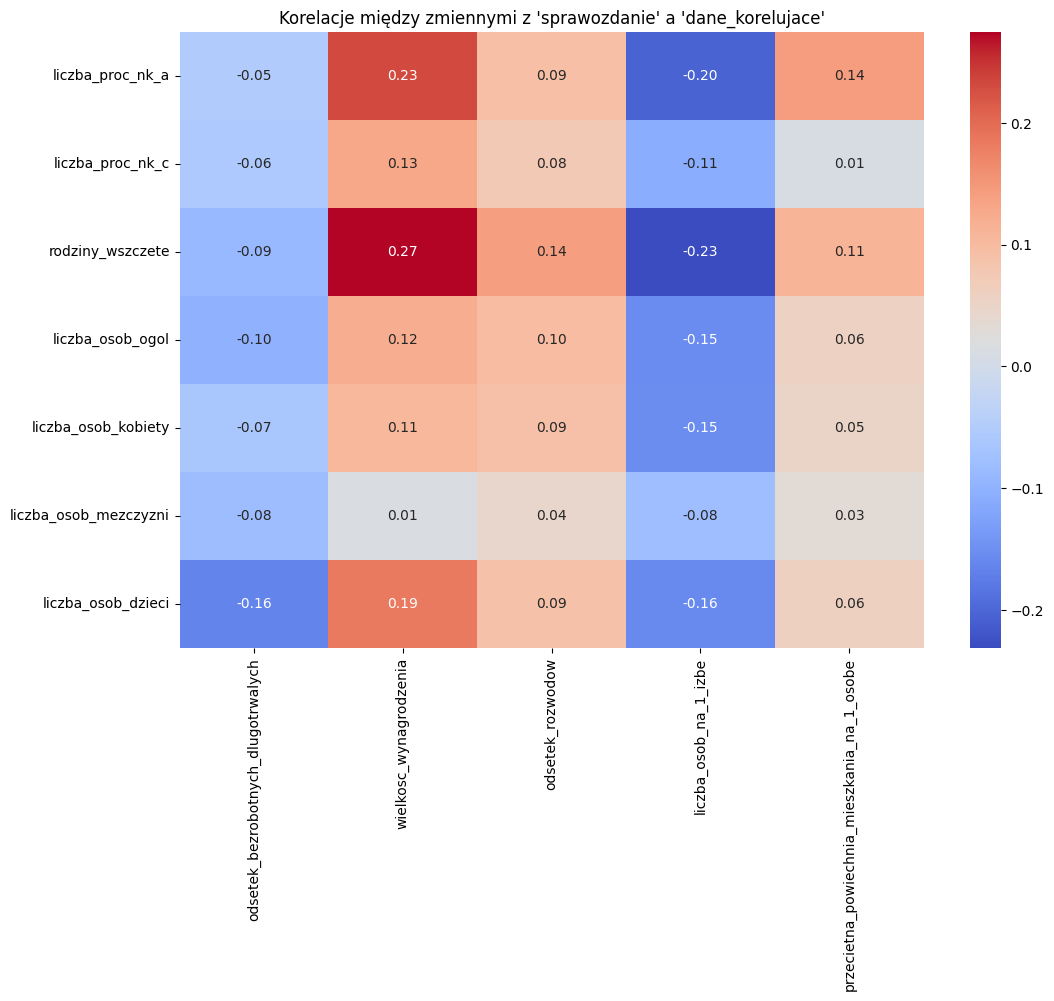

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Wizualizacja ogólnej macierzy korelacji
plt.figure(figsize=(12, 8))
sns.heatmap(corr_between, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelacje między zmiennymi z 'sprawozdanie' a 'dane_korelujace'")
plt.show()

In [43]:
merged_df

,woj_x,pow_x,rok,keso,liczba_proc_nk_a,liczba_proc_nk_c,rodziny_wszczete,liczba_osob_ogol,liczba_osob_kobiety,liczba_osob_mezczyzni,...,kod,pow_y,odsetek_bezrobotnych_dlugotrwalych,wielkosc_wynagrodzenia,odsetek_rozwodow,liczba_osob_na_1_izbe,przecietna_powiechnia_mieszkania_na_1_osobe,woj_kod,woj_y,kod_4digit
0,dolnośląskie,boleslawiecki,2023,300201011000,42,181,383,493,294.0,95.0,...,0201000,boleslawiecki,0.2585,6871,0.3928,0.61,32.4,02,dolnośląskie,0201
1,dolnośląskie,dzierzoniowski,2023,300202011000,65,132,291,402,216.0,26.0,...,0202000,dzierzoniowski,0.3396,6459,0.4966,0.65,28.7,02,dolnośląskie,0202
2,dolnośląskie,gorowski,2023,300204013000,23,56,125,273,211.0,23.0,...,0204000,gorowski,0.5330,6060,0.3388,0.64,30.2,02,dolnośląskie,0204
3,dolnośląskie,glogowski,2023,200203000000,36,199,428,770,333.0,72.0,...,0203000,glogowski,0.4918,6660,0.3771,0.65,27.9,02,dolnośląskie,0203
4,dolnośląskie,jaworski,2023,300205023000,12,59,119,123,93.0,8.0,...,0205000,jaworski,0.5452,7059,0.3684,0.64,29.9,02,dolnośląskie,0205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,świętokrzyskie,sandomierski,2014,302609022000,8,220,145,196,NaN,NaN,...,2609000,sandomierski,0.6265,3526,0.2105,0.79,26.2,26,świętokrzyskie,2609
3796,świętokrzyskie,skarzyski,2014,302610022000,32,62,166,215,NaN,NaN,...,2610000,skarzyski,0.6417,3395,0.3919,0.71,25.0,26,świętokrzyskie,2610
3797,świętokrzyskie,starachowicki,2014,302611022000,4,80,218,680,NaN,NaN,...,2611000,starachowicki,0.5965,3199,0.3761,0.79,23.7,26,świętokrzyskie,2611
3798,świętokrzyskie,staszowski,2014,302612012000,21,199,216,449,NaN,NaN,...,2612000,staszowski,0.4695,3589,0.2807,0.77,26.3,26,świętokrzyskie,2612


In [44]:
with pd.ExcelWriter('Sprawozdanie_przemoc_2014_2023_korelacja.xlsx') as writer:
 result.to_excel(writer, index=False, sheet_name='Sprawozdanie_przemoc_2014_2023_korelacja')

/usr/local/lib/python3.11/dist-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


In [45]:
result.to_csv('Sprawozdanie_przemoc_2014_2023_korelacja.csv', index=False)

In [46]:
result.to_excel("/content/drive/MyDrive/praca_licencjacka/Sprawozdanie_przemoc_2014_2023_korelacja.xlsx", sheet_name= "Sprawozdanie_przemoc_2014_2023_korelacja.xlsx" ,index=False)